# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

--------------------------------------------

# Другой подход к кластеризации

Пробуем новую идею, если не получается кластеризовать все обьекты, будем делать так: мы же уже знаем какие есть кластеры, просто раздадим метки по ключевым словам, олценим сколько осталось и проведем еще одну кластеризацию. 

In [4]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
widget_info = pl.read_csv(os.path.join(data_path, 'widget_info.csv'))
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

val_target.group_by('target').agg(pl.count('user_id'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


target,user_id
i32,u32
0,1227381
1,647575


In [5]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для последующего создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с указанием суффиксов
combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"  # Добавляем уникальный суффикс для каждого соединения
    )

In [6]:
# search_aggs
id_ = 4
suf = 'search'

# Сначала вычислим value_counts отдельно и развернем их в плоскую структуру
cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров (мера разнообразия)
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров (процент повторяющихся)
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\276488151.py:52: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [7]:
product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [8]:
train_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < val_start_date) &  # до валидации
        (pl.col('timestamp').dt.date() >= val_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общая активность
        pl.count().alias('total_actions_30d'),
        
        # Разбивка по типам действий
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        # Финансовые метрики
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        # Временные характеристики (исправлено!)
        (val_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        # Метрики кластеров
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        # Производные признаки
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\1964511306.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\1964511306.py:31: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [9]:
# Виджеты
existing_widgets = (
    actions_history
    .filter(pl.col('widget_name_id').is_not_null())
    .select(pl.col('widget_name_id').unique())
    .to_series()
    .to_list()
)

# Теперь создаем агрегаты только для существующих виджетов
widget_aggs = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() <= train_end_date) &
        (pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5)) &
        (pl.col('widget_name_id').is_not_null())
    )
    .group_by(['user_id', 'widget_name_id'])
    .agg(
        pl.count().alias('widget_count')
    )
    .join(
        actions_history
        .filter(
            (pl.col('timestamp').dt.date() <= train_end_date) &
            (pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5)) &
            (pl.col('widget_name_id').is_not_null())
        )
        .group_by('user_id')
        .agg(pl.count().alias('total_widget_actions')),
        on='user_id'
    )
    .with_columns(
        (pl.col('widget_count') / pl.col('total_widget_actions')).alias('widget_ratio')
    )
    .group_by('user_id')
    .agg([
        *[pl.col('widget_count').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_count') 
          for widget_id in existing_widgets],
        *[pl.col('widget_ratio').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_ratio') 
          for widget_id in existing_widgets]
    ])
    .fill_null(0)
)

if 'total_widget_actions' in widget_aggs.columns:
    widget_aggs = widget_aggs.drop('total_widget_actions')

C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\790935654.py:20: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('widget_count')
C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\790935654.py:30: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias('total_widget_actions')),


In [10]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )

df_main = df_main.join(product_cluster_aggs, on='user_id', how='left')
df_main = df_main.join(train_last_month_features, on='user_id', how='left')
df_main = df_main.join(widget_aggs, on='user_id', how='left')

df_pd = df_main.to_pandas()

columns_to_log = ['max_discount_price_click', 'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite',  'num_products_order', 'sum_discount_price_order', 'sum_discount_price_order',  'num_products_to_cart', 'max_discount_price_to_cart', 'num_search', 'unique_search_queries', 'num_search_last_month', 'num_search_last_week', 'search_daily_rate', 'search_cluster_switches', 'search_mean_query_len', 'search_main_cluster_query_len_diff']

df_pd = apply_log_transform(df_pd, columns_to_log, drop_original=True)

In [13]:
print(list(df_pd.columns))

['user_id', 'target', 'num_products_click', 'sum_discount_price_click', 'last_click_time', 'first_click_time', 'days_since_last_click', 'days_since_first_click', 'last_favorite_time', 'first_favorite_time', 'days_since_last_favorite', 'days_since_first_favorite', 'max_discount_price_order', 'last_order_time', 'first_order_time', 'days_since_last_order', 'days_since_first_order', 'sum_discount_price_to_cart', 'last_to_cart_time', 'first_to_cart_time', 'days_since_last_to_cart', 'days_since_first_to_cart', 'num_search_clusters', 'main_search_cluster', 'top3_search_clusters', 'top3_search_counts', 'recent_search_cluster', 'search_cluster_concentration', 'search_cluster_entropy', 'search_cluster_stability', 'main_search_cluster_time_ratio', 'search_mean_cluster_switch_days', 'days_since_last_search', 'days_since_first_search', 'last_search_time', 'first_search_time', 'num_product_clusters', 'main_product_cluster', 'product_cluster_concentration', 'product_cluster_entropy', 'product_cluster

In [15]:
knn_cols = ['log_sum_discount_price_order', 'sum_discount_price_to_cart', 'product_cluster_stability', 'log_num_products_order', 'product_cluster_concentration',  'days_since_first_order', 'days_since_last_order', 
            'widget_5_ratio', 'widget_14_ratio', 'widget_6_ratio', 'widget_3_ratio', 'widget_12_ratio', 'widget_16_ratio', 'widget_15_ratio', 'cart_adds_30d']

df_pd = add_knn_features_faiss(df_pd, knn_cols, n_neighbors=6, use_gpu=True)

Nans filled
Data scaled
Using CPU
FAISS index built
KNN search done


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:1115: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[key] = value
c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:1115: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

KNN features created


------------------------------------------------------

------------------------------------------------------

------------------------------------------------------

------------------------------------------------------

------------------------------------------------------

------------------------------------------------------

In [ ]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\2080839501.py:59: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [ ]:
id_ = 4
suf = 'search'

# Вычисляем top3 кластеров для валидации (аналогично трейну)
val_cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(val_cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\3574421506.py:51: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [ ]:
val_product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [19]:
test_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < test_start_date) &  # до теста
        (pl.col('timestamp').dt.date() >= test_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Те же метрики, что и для трейна
        pl.count().alias('total_actions_30d'),
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        (test_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\4126633476.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\4126633476.py:26: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [ ]:
# Сначала получим список реально существующих виджетов
existing_widgets = (
    actions_history
    .filter(pl.col('widget_name_id').is_not_null())
    .select(pl.col('widget_name_id').unique())
    .to_series()
    .to_list()
)

# Теперь создаем агрегаты только для существующих виджетов
widget_aggs = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() <= val_end_date) &
        (pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5)) &
        (pl.col('widget_name_id').is_not_null())
    )
    .group_by(['user_id', 'widget_name_id'])
    .agg(
        pl.count().alias('widget_count')
    )
    .join(
        actions_history
        .filter(
        (pl.col('timestamp').dt.date() <= val_end_date) &
        (pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5)) &
            (pl.col('widget_name_id').is_not_null())
        )
        .group_by('user_id')
        .agg(pl.count().alias('total_widget_actions')),
        on='user_id'
    )
    .with_columns(
        (pl.col('widget_count') / pl.col('total_widget_actions')).alias('widget_ratio')
    )
    .group_by('user_id')
    .agg([
        *[pl.col('widget_count').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_count') 
          for widget_id in existing_widgets],
        *[pl.col('widget_ratio').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_ratio') 
          for widget_id in existing_widgets]
    ])
    .fill_null(0)
)

if 'total_widget_actions' in widget_aggs.columns:
    widget_aggs = widget_aggs.drop('total_widget_actions')

C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\2185770286.py:20: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('widget_count')
C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\2185770286.py:30: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias('total_widget_actions')),


In [21]:
from local_utils import *

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

test_df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    test_df_main = (
        test_df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
test_df_main = test_df_main.join(val_product_cluster_aggs, on='user_id', how='left')
test_df_main = test_df_main.join(test_last_month_features, on='user_id', how='left')
test_df_main = test_df_main.join(widget_aggs, on='user_id', how='left')


test_df_pd = test_df_main.to_pandas()

test_df_pd = apply_log_transform(test_df_pd, columns_to_log, drop_original=True)

In [ ]:
test_df_pd = add_knn_features_faiss(test_df_pd, knn_cols, n_neighbors=6, use_gpu=True)

Nans filled
Data scaled
Using CPU
FAISS index built
KNN search done


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:1115: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[key] = value
c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:1115: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

KNN features created


In [23]:
def add_time_pattern_features(df_pd, actions_history, product_info):
    # Конвертируем product_info в LazyFrame если нужно
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    time_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            ((pl.col('timestamp').dt.hour() >= 6) & (pl.col('timestamp').dt.hour() < 12)).alias('new_is_morning'),
            ((pl.col('timestamp').dt.hour() >= 12) & (pl.col('timestamp').dt.hour() < 18)).alias('new_is_day'),
            (pl.col('timestamp').dt.weekday() >= 5).alias('new_is_weekend'),
            (pl.col('timestamp').dt.hour()).alias('new_hour'),
            (pl.col('timestamp').dt.weekday()).alias('new_dow')
        ])
        .join(
            product_info_lazy.select(['product_id', 'discount_price']), 
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
            (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
            (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
            pl.col('new_hour').value_counts().struct.field('count').entropy().alias('new_hour_entropy'),
            (pl.col('new_dow').filter(pl.col('new_dow') < 5).count() / 
             (pl.col('new_dow').filter(pl.col('new_dow') >= 5).count() + 1e-6)).alias('new_weekday_weekend_ratio'),
            (pl.col('discount_price').filter(pl.col('new_is_morning')).sum() / 
            (pl.col('new_is_morning').sum() + 1e-6)).alias('new_morning_avg_spend')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(time_aggs, on='user_id', how='left')

In [24]:
def add_brand_category_features(df_pd, actions_history, product_info):
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    brand_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .join(
            product_info_lazy.select(['product_id', 'brand', 'category_id', 'discount_price']),
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            pl.col('brand').n_unique().alias('new_unique_brands'),
            (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
            pl.col('category_id').n_unique().alias('new_unique_categories'),
            pl.col('category_id').value_counts().struct.field('count').max().alias('new_favorite_category_count'),
            (pl.col('discount_price').filter(pl.col('category_id') == 
             pl.col('category_id').mode().first()).mean()).alias('new_main_category_avg_price')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(brand_aggs, on='user_id', how='left')

In [25]:
def add_search_features(df_pd, search_history):
    search_aggs = (
        search_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            pl.col('search_query').str.split(' ').list.len().alias('new_query_word_count'),  # Исправлено здесь
            pl.col('search_query').str.contains(r'\d').alias('new_has_numbers')
        ])
        .group_by('user_id')
        .agg(
            pl.mean('new_query_word_count').alias('new_avg_query_length'),
            (pl.sum('new_has_numbers') / pl.count()).alias('new_numeric_query_ratio'),
            pl.col('search_query').filter(pl.col('search_query').str.len_chars() > 20).count().alias('new_long_queries_count')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(search_aggs, on='user_id', how='left')

In [26]:
# Загрузите данные заново (если нужно)
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet'))
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet'))
product_info = product_information

# Добавляем новые признаки
df_pd = add_time_pattern_features(df_pd, actions_history, product_info)
df_pd = add_brand_category_features(df_pd, actions_history, product_info) 
df_pd = add_search_features(df_pd, search_history)

C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\703708266.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\703708266.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\703708266.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\600433880.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\2438321060.py:12: Dep

In [27]:
test_df_pd = add_time_pattern_features(test_df_pd, actions_history, product_info)
test_df_pd = add_brand_category_features(test_df_pd, actions_history, product_info) 
test_df_pd = add_search_features(test_df_pd, search_history)

C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\703708266.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\703708266.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\703708266.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\600433880.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\2438321060.py:12: Dep

In [ ]:
from local_utils import *
import random


df_pd = df_pd[df_pd['user_id'] != 2346229]

lgb_tr, lgb_val = get_split(df_pd, val_size=0.35)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

lgb_params={
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.08,
    'boosting_type': 'gbdt',

    'max_depth': 7,

    'num_iterations': 400,
    'early_stopping_rounds': 100,
    'verbose': 1,
    'importance_type': 'split'
}

lgb_model = train_model_new(lgb_tr, lgb_val, cols, 'target', params=lgb_params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 420882, number of negative: 797838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48505
[LightGBM] [Info] Number of data points in the train set: 1218720, number of used features: 241
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345348 -> initscore=-0.639553
[LightGBM] [Info] Start training from score -0.639553
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.765223	valid's au

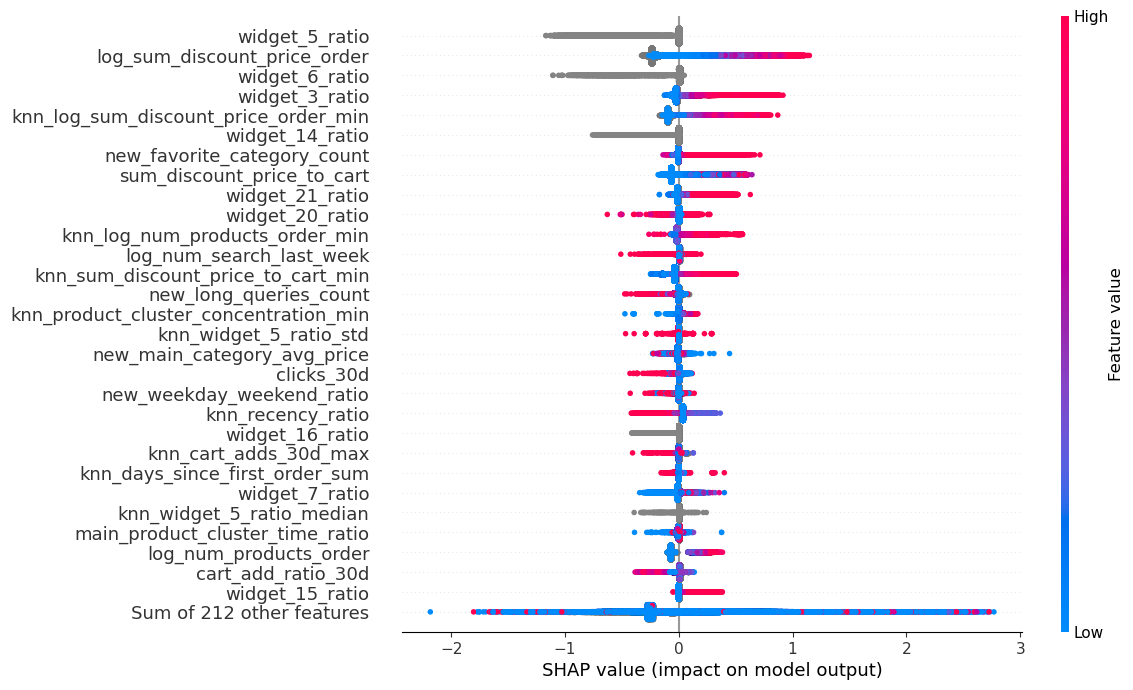

In [37]:
import shap

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer(lgb_val[cols])

shap.plots.beeswarm(shap_values, max_display=30, order=shap.Explanation.abs.max(0), plot_size=(10, 8))

feature_importance: [  4  76  49  28  96 119  26   2   8   1  34   4 119  96  61   3 119  40
  10  44 174 115  65  37  83   1  59 147 103  49  38  42  24  98  34  22
  31  16  96  22 185  66   0  54  70 111  18   0 144  27 102  66  19   8
 137  13   0 153  36  50  42   1  71  57   5   5  73   0  28 220   6  22
  58  45   0 130   2  30  29  20   3  64   0 152   5 137   0   0 161   0
  20 165   1  31 133  61  18  36 183 103 184 153   4 201 114  92  71  77
 117   0  62 148   0 169   3  47   4   0   0  13  48 186  27  32 109  28
  16  15  69   1   0 103  51  45  42  37   0 211  47 169  47  59  38 145
  40   0  53   0  24  67   0  89  56  20   0  32 140  67  24   1  29  60
 147  44  61  91  27  49  34  40   0  47   0 101   3  17  53  72   0   2
  50  22   0   0  31   7  18  67  74  48 186  93 175  36  42 124 109   0
  35  22  29   1   3 149  19   0  27 236  34   1  47 144  24   9  82  10
  10  16   0  37  75  51   7  37 112  34  12  36  50 107 121  66  35  40
   3   9  28  33  51 100 221] 


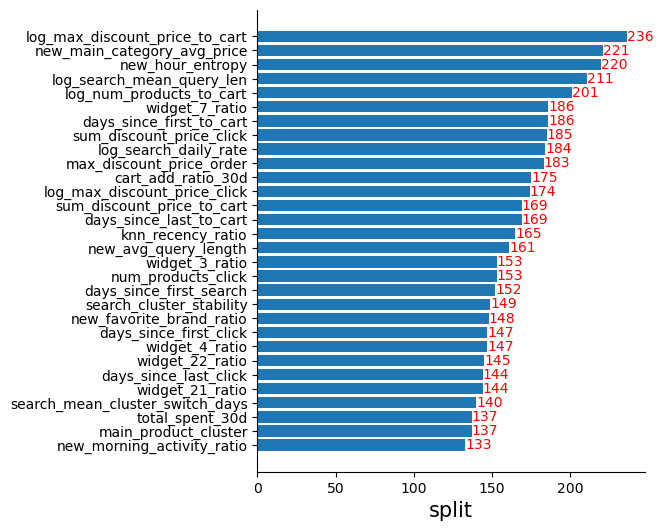

In [33]:
from local_utils import *

print('feature_importance:', lgb_model.feature_importances_, '\n')

plot_lgbm_importance(lgb_model, cols, importance_type='split', top_k=30, sklearn_style=True)

In [56]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]
lgb_tr, lgb_val = get_split(df_pd, val_size=0.37)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 
                                 'last_favorite_time', 'first_favorite_time', 
                                 'last_order_time', 'first_order_time', 
                                 'last_to_cart_time', 'first_to_cart_time', 
                                 'last_search_time', 'first_search_time',
                                 'top3_search_clusters', 'top3_search_counts', 
                                 'search_cluster_entropy', 'top3_product_counts', 
                                 'product_cluster_entropy', 'top3_product_clusters'})

lgb_params={
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.08,
    'boosting_type': 'gbdt',
    'max_depth': 7,
    'num_iterations': 400,
    'early_stopping_rounds': 100,
    'verbose': 1,
    'importance_type': 'split'
}

n_models = 10
feature_frac = 0.85

feature_subsets = []
remaining_features = set(cols.copy())

for i in range(n_models):
    if remaining_features:
        # Берем часть еще неиспользованных фичей
        n_new_features = max(1, int(len(remaining_features) / (n_models - i)))
        new_features = np.random.choice(list(remaining_features), n_new_features, replace=False)
        remaining_features -= set(new_features)
        
        # Добираем случайными фичами до 70%
        n_additional = int(len(cols) * feature_frac) - len(new_features)
        additional_features = np.random.choice(
            [f for f in cols if f not in new_features], 
            n_additional, 
            replace=False
        )
        
        feature_subset = list(new_features) + list(additional_features)
    else:
        # Все фичи уже использованы, просто берем случайные 70%
        feature_subset = np.random.choice(cols, int(len(cols) * feature_frac), replace=False)
    
    feature_subsets.append(feature_subset)

# Обучаем базовые модели и собираем их предсказания
base_models = []
train_predictions = np.zeros((len(lgb_tr), n_models))
val_predictions = np.zeros((len(lgb_val), n_models))

for i, feature_subset in enumerate(feature_subsets):
    print(f"Training base model {i+1} on {len(feature_subset)} features...")
    
    # Обучаем модель на подвыборке фичей
    model = train_model_new(
        lgb_tr, 
        lgb_val, 
        feature_subset, 
        'target', 
        params=lgb_params, 
        shadow_features=False, 
        sklearn_style=True
    )
    base_models.append(model)
    
    # Получаем предсказания на трейне и валидации
    train_predictions[:, i] = model.predict_proba(lgb_tr[feature_subset])[:, 1]
    val_predictions[:, i] = model.predict_proba(lgb_val[feature_subset])[:, 1]

Training base model 1 on 204 features...
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 408040, number of negative: 773181
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40562
[LightGBM] [Info] Number of data points in the train set: 1181221, number of used features: 204
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345439 -> initscore=-0.639148
[LightGBM] [Info] Start training from score -0.639148
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 roun

In [57]:
res = []
for i, m in enumerate(base_models):
    feature_subset = feature_subsets[i]
    res.append(m.predict_proba(test_df_pd[feature_subset])[:, 1])

In [58]:
# 1. Создаем DataFrame с предсказаниями (как в предыдущих шагах)
predictions_array = np.array(res).T
res_df = pd.DataFrame(predictions_array, columns=[f'Model_{i+1}' for i in range(len(res))])

# 2. Добавляем user_id из исходных данных
res_df['user_id'] = test_df_pd['user_id'].values  # или reset_index(), если нужно

# 3. Добавляем усредненное предсказание (если нужно)
res_df['predict'] = res_df[[f'Model_{i+1}' for i in range(len(res))]].mean(axis=1)

# 4. Сохраняем только нужные колонки
res_df

,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,user_id,predict
0,0.173827,0.248508,0.231463,0.167810,0.208889,0.169531,0.214075,0.257198,0.206631,0.201489,1342,0.207942
1,0.681747,0.665640,0.733907,0.811398,0.754894,0.664908,0.763748,0.702940,0.777980,0.767390,9852,0.732455
2,0.232585,0.233090,0.179701,0.292133,0.237340,0.220562,0.213140,0.325485,0.198253,0.236676,10206,0.236897
3,0.231439,0.223280,0.193249,0.281034,0.282194,0.226778,0.219595,0.317332,0.195979,0.243421,11317,0.241430
4,0.582343,0.577889,0.557760,0.537082,0.523719,0.580173,0.575714,0.531289,0.554843,0.495697,13289,0.551651
...,...,...,...,...,...,...,...,...,...,...,...,...
2068419,0.212121,0.219899,0.176815,0.212662,0.278998,0.208673,0.209431,0.300180,0.173598,0.227028,11157283,0.221941
2068420,0.055895,0.099776,0.102835,0.063206,0.137005,0.071752,0.110750,0.086100,0.084350,0.056466,11160395,0.086813
2068421,0.594878,0.639179,0.616858,0.650818,0.599052,0.608276,0.609463,0.662363,0.608280,0.619516,11165052,0.620868
2068422,0.506698,0.491114,0.517970,0.603614,0.641442,0.435787,0.492262,0.489740,0.521540,0.426809,11168218,0.512698


In [59]:
res_df[['user_id', 'predict']].to_csv('alast_ens_8260.csv', index=False)

In [82]:
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]

lgb_tr, lgb_val = get_split(df_pd, val_size=0.35)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

lgb_params={
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.08,
    'boosting_type': 'gbdt',
    'max_depth': 7,
    'num_iterations': 400,
    'early_stopping_rounds': 100,
    'verbose': 1,
    'importance_type': 'split'
}

eee_lgb_model = train_model_new(lgb_tr, lgb_val, cols, 'target', params=lgb_params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 420882, number of negative: 797838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.172972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48505
[LightGBM] [Info] Number of data points in the train set: 1218720, number of used features: 241
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345348 -> initscore=-0.639553
[LightGBM] [Info] Start training from score -0.639553
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.765223	valid's au

In [89]:
# Получаем предсказания вероятностей для тестовых данных
test_predictions = eee_lgb_model.predict_proba(df_pd[cols])[:, 1]
test_predictions_rounded = np.round(test_predictions, 2)

shap_df_pd = df_pd.copy()

# Добавляем предсказания в тестовый DataFrame
shap_df_pd['predicted_prob'] = test_predictions
shap_df_pd['predicted_prob_rounded'] = test_predictions_rounded

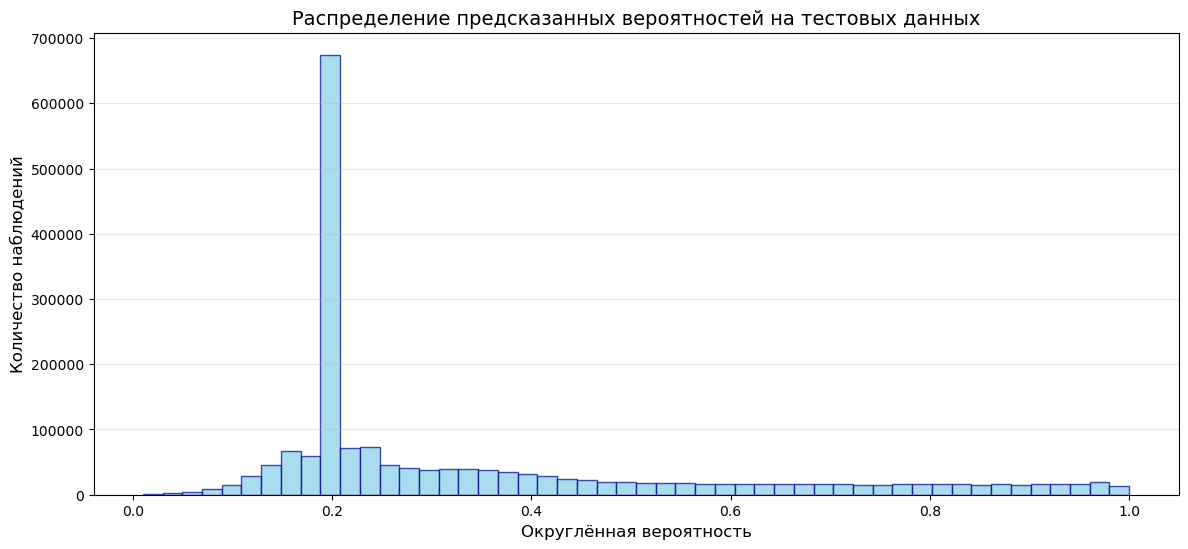

In [90]:
plt.figure(figsize=(14, 6))
plt.hist(test_predictions_rounded, bins=50, color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('Распределение предсказанных вероятностей на тестовых данных', fontsize=14)
plt.xlabel('Округлённая вероятность', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [91]:
# Выделяем объекты с неопределёнными предсказаниями (0.15-0.25)
uncertain_samples = shap_df_pd[(test_predictions_rounded >= 0.15) & 
                             (test_predictions_rounded <= 0.25)]

print(f"Количество неопределённых предсказаний: {len(uncertain_samples)}")
print(f"Доля от общего числа: {len(uncertain_samples)/len(shap_df_pd):.2%}")

Количество неопределённых предсказаний: 968941
Доля от общего числа: 51.68%


c:\Users\Admin\anaconda3\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_100192\1911305788.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, shap_sample, plot_type="bar", max_display=15)


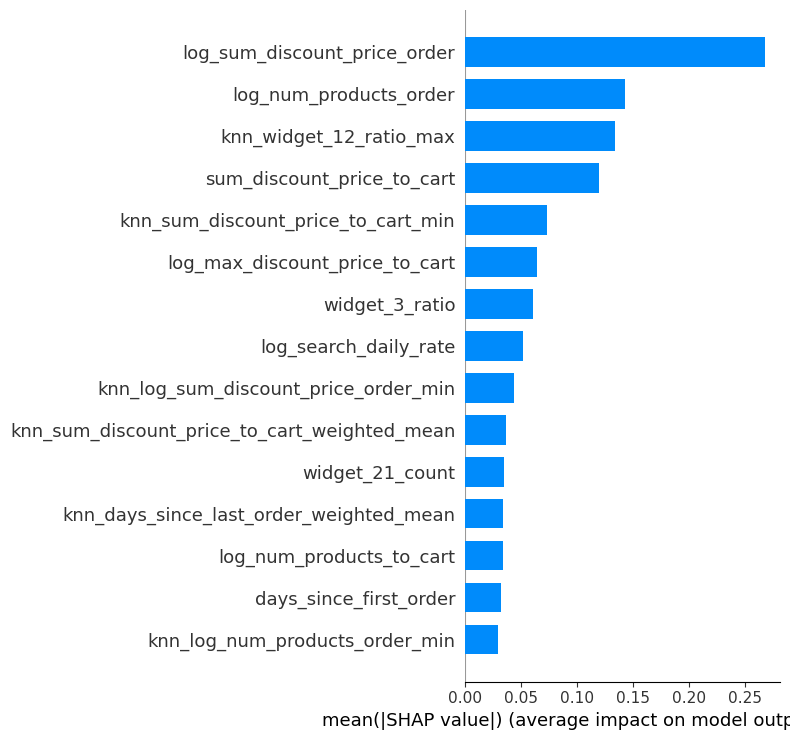

In [92]:
import shap

# Инициализируем explainer
explainer = shap.TreeExplainer(eee_lgb_model)

# Вычисляем SHAP значения для подвыборки (для экономии времени)
shap_sample = shap_df_pd[cols].sample(min(1000, len(shap_df_pd)), random_state=42)
shap_values = explainer.shap_values(shap_sample)

# Визуализация важности признаков
shap.summary_plot(shap_values, shap_sample, plot_type="bar", max_display=15)

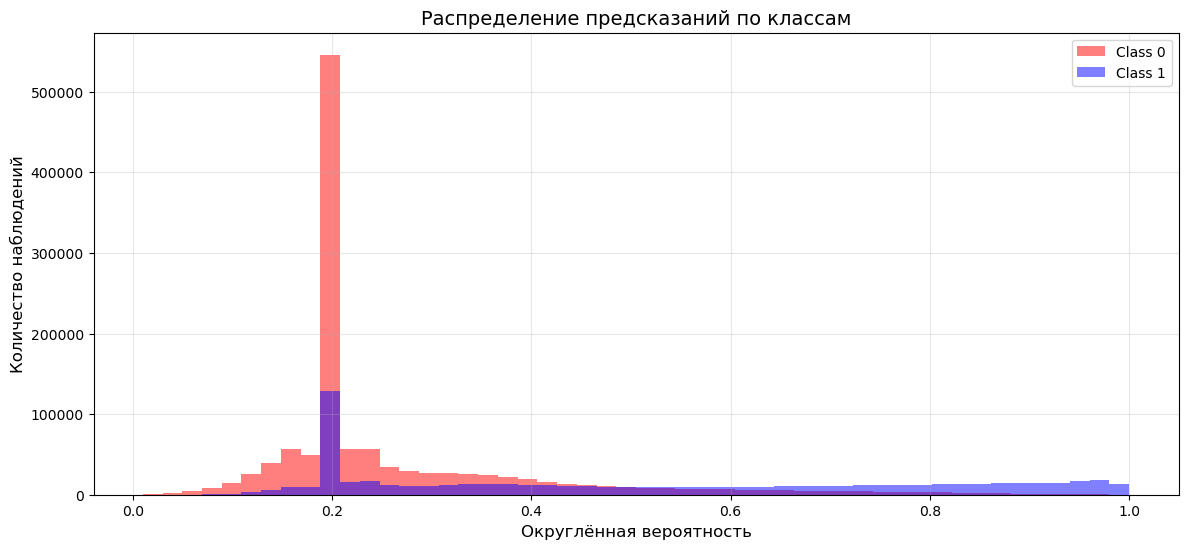

In [93]:
# Если есть истинные метки (target) в тестовых данных
if 'target' in shap_df_pd.columns:
    plt.figure(figsize=(14, 6))
    
    # Для класса 0
    plt.hist(test_predictions_rounded[shap_df_pd['target'] == 0], 
             bins=50, alpha=0.5, color='red', label='Class 0')
    
    # Для класса 1
    plt.hist(test_predictions_rounded[shap_df_pd['target'] == 1], 
             bins=50, alpha=0.5, color='blue', label='Class 1')
    
    plt.title('Распределение предсказаний по классам', fontsize=14)
    plt.xlabel('Округлённая вероятность', fontsize=12)
    plt.ylabel('Количество наблюдений', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [94]:
# Примеры с максимальной неопределённостью
uncertain_examples = shap_df_pd.iloc[np.argsort(np.abs(test_predictions - 0.5))[:5]]

# Примеры с явными ошибками (если есть target)
if 'target' in shap_df_pd.columns:
    wrong_predictions = shap_df_pd[
        ((test_predictions > 0.5) & (shap_df_pd['target'] == 0)) | 
        ((test_predictions < 0.5) & (shap_df_pd['target'] == 1))
    ]
    print(f"\nКоличество ошибочных предсказаний: {len(wrong_predictions)}")


Количество ошибочных предсказаний: 440326


In [96]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

# Сводная статистика
report = {
    "Общее количество наблюдений": len(shap_df_pd),
    "Средняя предсказанная вероятность": test_predictions.mean(),
    "Доля неопределённых предсказаний (0.15-0.25)": len(uncertain_samples)/len(shap_df_pd),
}

if 'target' in shap_df_pd.columns:
    report.update({
        "AUC-ROC": roc_auc_score(shap_df_pd['target'], test_predictions),
        "Accuracy": accuracy_score(shap_df_pd['target'], test_predictions > 0.5),
        "Precision": precision_score(shap_df_pd['target'], test_predictions > 0.5),
        "Recall": recall_score(shap_df_pd['target'], test_predictions > 0.5)
    })

pd.DataFrame.from_dict(report, orient='index', columns=['Значение'])

,Значение
Общее количество наблюдений,1.874955e+06
Средняя предсказанная вероятность,3.450578e-01
Доля неопределённых предсказаний (0.15-0.25),5.167809e-01
AUC-ROC,7.685483e-01
Accuracy,7.651538e-01
Precision,7.542614e-01
Recall,4.746941e-01


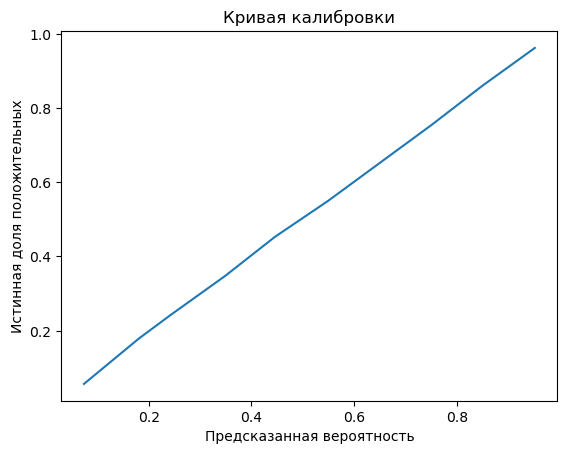

In [97]:
# Калибровка модели
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(shap_df_pd['target'], test_predictions, n_bins=10)
plt.plot(prob_pred, prob_true)
plt.xlabel("Предсказанная вероятность")
plt.ylabel("Истинная доля положительных")
plt.title("Кривая калибровки")
plt.show()

# Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': cols,
    'importance': eee_lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

In [98]:
# Создаем датафрейм с ошибочными предсказаниями
wrong_predictions = shap_df_pd.assign(
    predicted_prob=test_predictions,
    predicted_class=(test_predictions > 0.5).astype(int)
).query(
    "(predicted_class == 1 and target == 0) or (predicted_class == 0 and target == 1)"
).copy()

# Добавляем разницу между предсказанием и фактическим значением
wrong_predictions['error_magnitude'] = np.abs(wrong_predictions['predicted_prob'] - wrong_predictions['target'])

print(f"Всего ошибочных предсказаний: {len(wrong_predictions)}")
print(f"Доля ошибок: {len(wrong_predictions)/len(shap_df_pd):.2%}")

Всего ошибочных предсказаний: 440326
Доля ошибок: 23.48%


In [99]:
# Разделяем на False Positive и False Negative
fp = wrong_predictions[wrong_predictions['target'] == 0]
fn = wrong_predictions[wrong_predictions['target'] == 1]

print("\nРаспределение ошибок:")
print(f"False Positive (неверно предсказали 1): {len(fp)} ({len(fp)/len(wrong_predictions):.2%})")
print(f"False Negative (неверно предсказали 0): {len(fn)} ({len(fn)/len(wrong_predictions):.2%})")


Распределение ошибок:
False Positive (неверно предсказали 1): 100151 (22.74%)
False Negative (неверно предсказали 0): 340175 (77.26%)


In [105]:
# Сначала выделим только оригинальные числовые признаки (исключая созданные временные колонки)
original_numerical_cols = [col for col in wrong_predictions.select_dtypes(include=np.number).columns 
                         if col not in ['predicted_prob', 'predicted_class', 'error_magnitude', 'target']]

print(f"Анализируем {len(original_numerical_cols)} числовых признаков")

# Сравнение средних значений
error_stats = wrong_predictions[original_numerical_cols].mean().to_frame('errors_mean')
global_stats = shap_df_pd[original_numerical_cols].mean().to_frame('global_mean')

result = (pd.concat([error_stats, global_stats], axis=1)
          .assign(difference=lambda x: x['errors_mean'] - x['global_mean'])
          .sort_values('difference', key=abs, ascending=False))

# Красивое отображение топ-10 признаков с наибольшими различиями
(top_diff_10 := result.head(10).style.background_gradient(
    subset=['difference'], cmap='coolwarm', vmin=-1, vmax=1
).format("{:.3f}"))

Анализируем 243 числовых признаков


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,errors_mean,global_mean,difference
new_weekday_weekend_ratio,1954994.204,1705520.236,249473.968
total_spent_30d,10722.049,15349.570,-4627.521
sum_discount_price_click,17042.633,21014.750,-3972.117
user_id,5593987.704,5592275.104,1712.600
max_discount_price_order,1156.630,1293.846,-137.216
new_main_category_avg_price,809.695,836.784,-27.089
widget_22_count,38.452,54.069,-15.617
total_actions_30d,24.774,39.809,-15.035
avg_price_30d,677.379,669.278,8.101
widget_3_count,7.716,15.456,-7.740


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


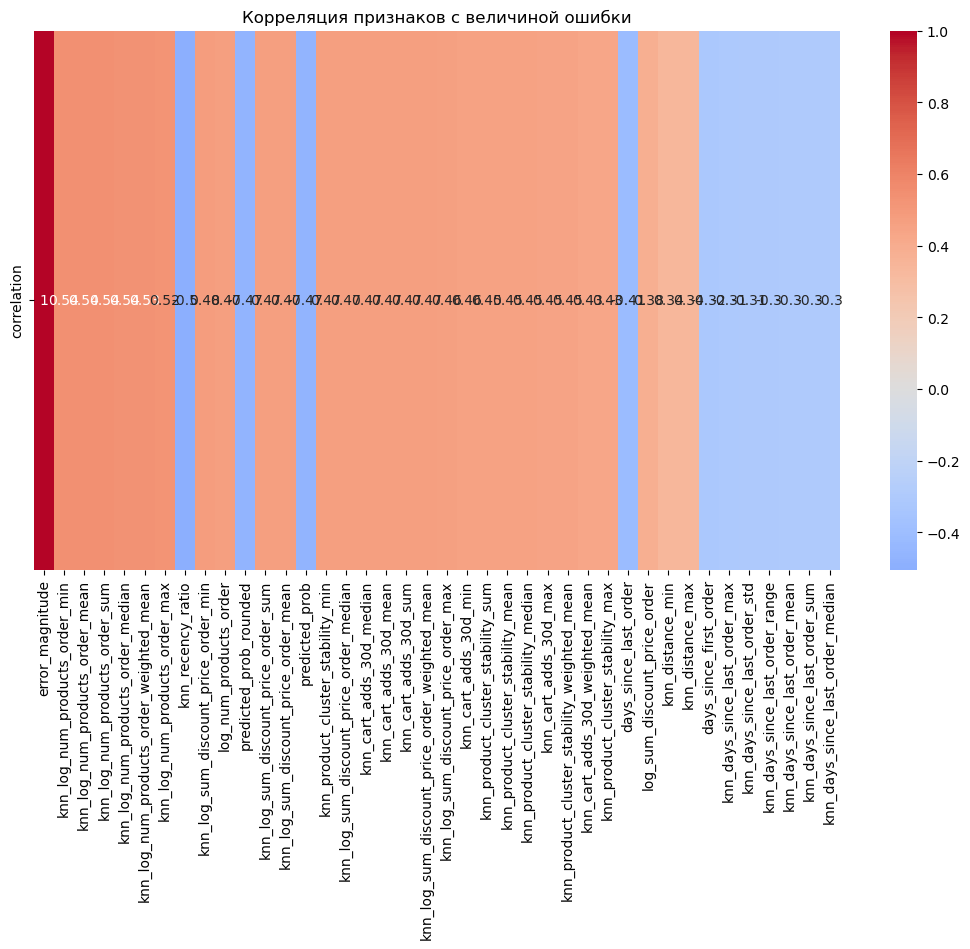

In [113]:
# Признаки с наибольшей разницей между ошибочными и правильными предсказаниями
plt.figure(figsize=(13, 7))
sns.heatmap(
    wrong_predictions[numerical_cols].corrwith(wrong_predictions['error_magnitude']).to_frame('correlation').sort_values('correlation', key=abs, ascending=False).head(40).T,
    annot=True, cmap='coolwarm', center=0
)
plt.title('Корреляция признаков с величиной ошибки')
plt.show()

In [102]:
# Самые "сильные" ошибки (где модель была наиболее уверена, но ошиблась)
top_errors = wrong_predictions.sort_values('error_magnitude', ascending=False).head(5)

print("\nТоп-5 самых уверенных, но ошибочных предсказаний:")
display(top_errors[['target', 'predicted_prob', 'error_magnitude'] + numerical_cols[:5]])


Топ-5 самых уверенных, но ошибочных предсказаний:


,target,predicted_prob,error_magnitude,user_id,target,num_products_click,sum_discount_price_click,days_since_last_click
810207,0,0.996954,0.996954,2057211,0,608.0,225518.0,0.0
18978,0,0.996703,0.996703,8569104,0,218.0,349317.0,0.0
437733,0,0.994844,0.994844,342722,0,207.0,115874.0,0.0
435161,0,0.993475,0.993475,5316413,0,155.0,35778.0,5.0
553687,0,0.992946,0.992946,3215244,0,204.0,89221.0,2.0


In [103]:
# Сравнение распределений для ключевых признаков
key_features = error_stats.sort_values('difference', key=abs, ascending=False).index[:3]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, feat in zip(axes, key_features):
    sns.kdeplot(data=shap_df_pd, x=feat, label='Общее', ax=ax)
    sns.kdeplot(data=wrong_predictions, x=feat, label='Ошибки', ax=ax)
    ax.set_title(f'Распределение {feat}')
    ax.legend()
plt.tight_layout()
plt.show()

KeyError: 'difference'

In [104]:
# Кластеризация ошибок для выявления паттернов
from sklearn.cluster import KMeans

# Выбираем топ-10 самых коррелированных с ошибками признаков
top_error_features = wrong_predictions[numerical_cols].corrwith(wrong_predictions['error_magnitude']).sort_values(key=abs, ascending=False).head(10).index.tolist()

# Кластеризация
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(wrong_predictions[top_error_features])

# Анализ кластеров
cluster_analysis = (wrong_predictions.assign(cluster=clusters)
                   .groupby('cluster')[top_error_features + ['error_magnitude']]
                   .mean())

print("\nХарактеристики кластеров ошибок:")
display(cluster_analysis.style.background_gradient(cmap='Blues'))

c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

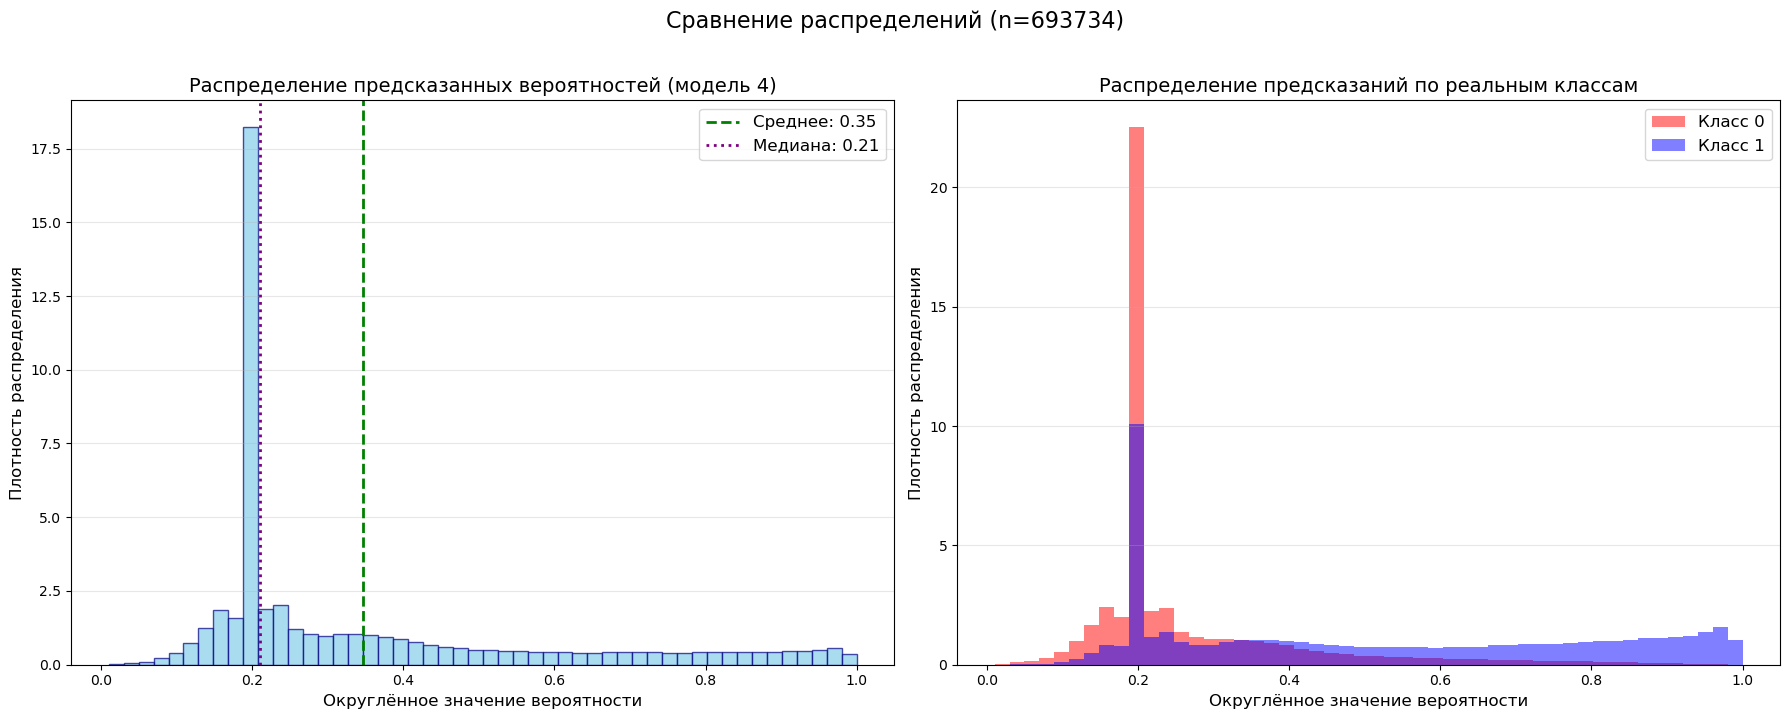

Среднее предсказание для класса 0: 0.260
Среднее предсказание для класса 1: 0.510


In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Получаем предсказания
predict = base_models[4].predict_proba(lgb_val[feature_subsets[4]])[:, 1]
predict_rounded = np.round(predict, 2)  # Округляем до 0.01

# Создаём фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Первый график - распределение предсказаний
n1, bins1, patches1 = ax1.hist(predict_rounded, bins=50, color='skyblue', 
                              edgecolor='navy', alpha=0.7, density=True)

# Добавляем статистики
mean_val = np.mean(predict_rounded)
median_val = np.median(predict_rounded)
ax1.axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Среднее: {mean_val:.2f}')
ax1.axvline(median_val, color='purple', linestyle=':', linewidth=2, label=f'Медиана: {median_val:.2f}')

ax1.set_title('Распределение предсказанных вероятностей (модель 4)', fontsize=14)
ax1.set_xlabel('Округлённое значение вероятности', fontsize=12)
ax1.set_ylabel('Плотность распределения', fontsize=12)
ax1.grid(axis='y', alpha=0.3)
ax1.legend(fontsize=12)

# Второй график - распределение реальных меток
target_values = lgb_val['target'].values
ax2.hist(predict_rounded[target_values == 0], bins=bins1, color='red', alpha=0.5, density=True, label='Класс 0')
ax2.hist(predict_rounded[target_values == 1], bins=bins1, color='blue', alpha=0.5, density=True, label='Класс 1')

ax2.set_title('Распределение предсказаний по реальным классам', fontsize=14)
ax2.set_xlabel('Округлённое значение вероятности', fontsize=12)
ax2.set_ylabel('Плотность распределения', fontsize=12)
ax2.grid(axis='y', alpha=0.3)
ax2.legend(fontsize=12)

# Общие настройки
plt.suptitle(f'Сравнение распределений (n={len(predict)})', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Дополнительная статистика
print(f"Среднее предсказание для класса 0: {np.mean(predict_rounded[target_values == 0]):.3f}")
print(f"Среднее предсказание для класса 1: {np.mean(predict_rounded[target_values == 1]):.3f}")

In [70]:
uncertain_mask = (predict_rounded >= 0.15) & (predict_rounded <= 0.25)
problem_samples = lgb_val[uncertain_mask].copy()
problem_samples['predict'] = predict_rounded[uncertain_mask]

In [72]:
import shap

# Инициализируем explainer на всей модели
explainer = shap.TreeExplainer(base_models[4])

# Вычисляем SHAP только для проблемных объектов
shap_values_problem = explainer.shap_values(problem_samples[feature_subsets[4]])

c:\Users\Admin\anaconda3\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [78]:
class1_problems = problem_samples[problem_samples['target'] == 1]
class0_problems = problem_samples[problem_samples['target'] == 0]

import numpy as np
import pandas as pd
import shap

# Убедимся, что shap_values_problem имеет правильную структуру
if isinstance(shap_values_problem, list):
    print(f"SHAP значений для класса 0: {np.array(shap_values_problem[0]).shape}")
    print(f"SHAP значений для класса 1: {np.array(shap_values_problem[1]).shape}")
    shap_matrix = np.array(shap_values_problem[1])  # Используем SHAP для класса 1
else:
    shap_matrix = np.array(shap_values_problem)  # Если SHAP значения не в списке

print(f"Размерность матрицы признаков: {class1_problems[feature_subsets[4]].shape}")

Размерность матрицы признаков: (69814, 204)


In [75]:
print(f"Тип shap_values_problem: {type(shap_values_problem)}")
if isinstance(shap_values_problem, list):
    print(f"SHAP для класса 0: {shap_values_problem[0].shape}")
    print(f"SHAP для класса 1: {shap_values_problem[1].shape}")

Тип shap_values_problem: <class 'numpy.ndarray'>


In [80]:
len(shap_df)

359731

In [81]:
len(features_df)

69814

In [79]:
# Преобразуем данные в правильный формат
shap_df = pd.DataFrame(shap_matrix, columns=feature_subsets[4])
features_df = class1_problems[feature_subsets[4]].reset_index(drop=True)

# Убедимся, что размерности совпадают
assert len(shap_df) == len(features_df), "Размерности SHAP и признаков не совпадают!"

# Строим summary plot с проверкой
try:
    shap.summary_plot(
        shap_df.values, 
        features_df,
        plot_type='dot',
        max_display=10,
        title='Влияние признаков на класс 1 в проблемных случаях'
    )
except Exception as e:
    print(f"Ошибка при построении графика: {str(e)}")
    print("Пробуем альтернативный вариант...")
    
    # Альтернатива через bar plot
    shap.plots.bar(
        shap.Explanation(
            values=shap_df.values,
            base_values=np.repeat(explainer.expected_value[1], len(shap_df)),
            data=features_df.values,
            feature_names=feature_subsets[4]
        ),
        max_display=10
    )

AssertionError: Размерности SHAP и признаков не совпадают!

In [ ]:
class0_problems = problem_samples[problem_samples['target'] == 0]

# Сводный анализ через summary plot
shap.summary_plot(
    shap_values_problem[0], 
    class0_problems[feature_subsets[4]],
    plot_type='bar',
    max_display=15
)

In [ ]:
# SHAP для нормальных предсказаний класса 1
normal_class1 = lgb_val[(predict_rounded > 0.7) & (lgb_val['target'] == 1)]
shap_normal = explainer.shap_values(normal_class1[feature_subsets[4]])

# Сравниваем средние абсолютные SHAP-значения
problem_importance = np.abs(shap_values_problem[1]).mean(0)
normal_importance = np.abs(shap_normal[1]).mean(0)

# Разница в важности признаков
importance_diff = pd.DataFrame({
    'feature': feature_subsets[4],
    'problem_importance': problem_importance,
    'normal_importance': normal_importance,
    'difference': problem_importance - normal_importance
}).sort_values('difference', ascending=False)

print(importance_diff.head(10))

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

top_problem_feature = importance_diff.iloc[0]['feature']

PartialDependenceDisplay.from_estimator(
    base_models[4], 
    lgb_val[feature_subsets[4]], 
    features=[top_problem_feature],
    kind='both'  # и средний эффект, и индивидуальный
)
plt.show()